CHORE: LOADING THE DATASET

In [5]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

CHORE: PLOTTING THE DATASET

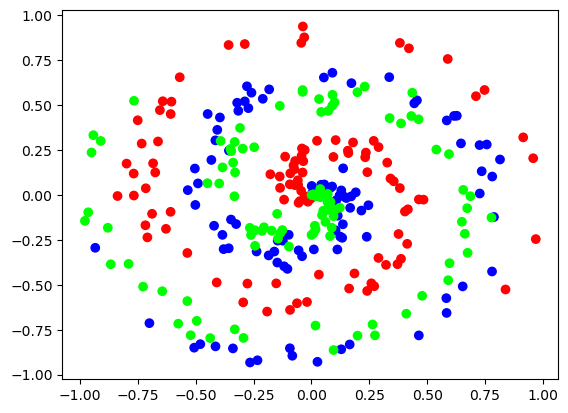

In [6]:
import matplotlib.pyplot as plt
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

FEAT: DENSE LAYER: FORWARD AND BACKWARD PASS

In [7]:
# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input ones, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


FEAT: CODE RELU ACTIVATION: FORWARD AND BACKWARD PASS

In [8]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let’s make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

FEAT: CODE SOFTMAX ACTIVATION: FORWARD PASS

In [9]:
# Softmax activation
class Activation_Softmax:
 # Forward pass
 def forward(self, inputs):
 # Get unnormalized probabilities
  exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
 # Normalize them for each sample
  probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
  self.output = probabilities

FEAT: CODE LOSS CLASS

In [10]:
    # Common loss class
    class Loss:
        # Calculates the data and regularization losses
        # given model output and ground truth values
        def calculate(self, output, y):
         # Calculate sample losses
         sample_losses = self.forward(output, y)
         # Calculate mean loss
         data_loss = np.mean(sample_losses)
         # Return loss
         return data_loss

FEAT: CODE CATEGORICAL CROSS ENTROPY LOSS: FORWARD AND BACKWARD PASS

In [11]:
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples



FEAT: COMBINED SOFTMAX ACTIVATION AND CATEGORICAL CROSS ENTROPY FOR LAST LAYER: FORWARD AND BACKWARD PASS

In [12]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy:
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

FEAT: ADAM OPTIMIZER

In [13]:
import numpy as np

# Adam optimizer
class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first pass and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

TEST: TRANNING THE NEURAL NETWORK

In [14]:
import numpy as np

# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.343, loss: 1.099, lr: 0.02
epoch: 100, acc: 0.490, loss: 0.981, lr: 0.01998021958261321
epoch: 200, acc: 0.543, loss: 0.876, lr: 0.019960279044701046
epoch: 300, acc: 0.580, loss: 0.838, lr: 0.019940378268975763
epoch: 400, acc: 0.610, loss: 0.801, lr: 0.01992051713662487
epoch: 500, acc: 0.730, loss: 0.728, lr: 0.01990069552930875
epoch: 600, acc: 0.710, loss: 0.674, lr: 0.019880913329158343
epoch: 700, acc: 0.730, loss: 0.637, lr: 0.019861170418772778
epoch: 800, acc: 0.737, loss: 0.613, lr: 0.019841466681217078
epoch: 900, acc: 0.763, loss: 0.601, lr: 0.01982180200001982
epoch: 1000, acc: 0.767, loss: 0.588, lr: 0.019802176259170884
epoch: 1100, acc: 0.763, loss: 0.579, lr: 0.01978258934311912
epoch: 1200, acc: 0.767, loss: 0.575, lr: 0.01976304113677013
epoch: 1300, acc: 0.757, loss: 0.568, lr: 0.019743531525483964
epoch: 1400, acc: 0.763, loss: 0.562, lr: 0.01972406039507293
epoch: 1500, acc: 0.767, loss: 0.557, lr: 0.019704627631799327
epoch: 1600, acc: 0.780, lo

TEST: TRAINNING DATA WITHOUT OPTIMIZERS

In [15]:
# Validate the model
# Create test dataset
X_test, y_test = spiral_data(samples=100, classes=3)
# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
 y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation, acc: 0.643, loss: 0.972


L1/L2 REGULARIZER

THE ENTIRE LAYER CLASS WITH REGULARIZATION

In [16]:
import numpy as np 

class Layer_Dense:
    # Layer initialization 
    def __init__(self, n_inputs, n_neurons, 
                 weight_regularizer_l1 = 0, weight_regularizer_l2 = 0, 
                 bias_regularizer_l1 = 0, bias_regularizer_l2 =0):
        # Initialize weights & biases 
        self.weights = 0.01 * np.random.rand(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input ones, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization

        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        # L2 on biases 
        if self.bias_regularizer_l2 > 0: 
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

THE ENTIRE LOSS CLASS

In [17]:
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

    # Regularization loss calculation
    def regularization_loss(self, layer):
        # 0 by default
        regularization_loss = 0

        # L1 regularization – weights
        # Calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

        # L2 regularization – weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

        # L1 regularization – biases
        # Calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        # L2 regularization – biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss


TRAINING A SIMPLE NEURAL NETWORK WITHOUT REGULARIZATION

In [18]:
import numpy as np

# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values

## NO REGULARIZATION
dense1 = Layer_Dense(2, 64)

## WITH REGULARIZATION
# dense1 = Layer_Dense(2, 64, weight_regularizer_l2 = 5e-4, bias_regularizer_l2 = 5e-4)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    data_loss = loss_activation.forward(dense2.output, y)

    
    # Calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

    # Calculate overall loss 
    loss = data_loss + regularization_loss
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} ' +
              f'(data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()


epoch: 0, acc: 0.313, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.02
epoch: 100, acc: 0.577, loss: 0.897 (data_loss: 0.897, reg_loss: 0.000), lr: 0.01998021958261321
epoch: 200, acc: 0.697, loss: 0.678 (data_loss: 0.678, reg_loss: 0.000), lr: 0.019960279044701046
epoch: 300, acc: 0.753, loss: 0.568 (data_loss: 0.568, reg_loss: 0.000), lr: 0.019940378268975763
epoch: 400, acc: 0.797, loss: 0.506 (data_loss: 0.506, reg_loss: 0.000), lr: 0.01992051713662487
epoch: 500, acc: 0.803, loss: 0.467 (data_loss: 0.467, reg_loss: 0.000), lr: 0.01990069552930875
epoch: 600, acc: 0.840, loss: 0.429 (data_loss: 0.429, reg_loss: 0.000), lr: 0.019880913329158343
epoch: 700, acc: 0.850, loss: 0.398 (data_loss: 0.398, reg_loss: 0.000), lr: 0.019861170418772778
epoch: 800, acc: 0.857, loss: 0.379 (data_loss: 0.379, reg_loss: 0.000), lr: 0.019841466681217078
epoch: 900, acc: 0.860, loss: 0.357 (data_loss: 0.357, reg_loss: 0.000), lr: 0.01982180200001982
epoch: 1000, acc: 0.873, loss: 0.343 (data

In [19]:

# Validate the model
# Create test dataset
X_test, y_test = spiral_data(samples=100, classes=3)
# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
 y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation, acc: 0.787, loss: 1.263


EFFECT OF MORE TRAINING DATA WITH REGULARIZATION

In [20]:
import numpy as np

# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values

## NO REGULARIZATION
# dense1 = Layer_Dense(2, 64)

## WITH REGULARIZATION
dense1 = Layer_Dense(2, 64, weight_regularizer_l2 = 5e-4, bias_regularizer_l2 = 5e-4)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    data_loss = loss_activation.forward(dense2.output, y)

    
    # Calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

    # Calculate overall loss 
    loss = data_loss + regularization_loss
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} ' +
              f'(data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()


epoch: 0, acc: 0.347, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.02
epoch: 100, acc: 0.673, loss: 0.840 (data_loss: 0.801, reg_loss: 0.040), lr: 0.01998021958261321
epoch: 200, acc: 0.740, loss: 0.701 (data_loss: 0.630, reg_loss: 0.071), lr: 0.019960279044701046
epoch: 300, acc: 0.790, loss: 0.628 (data_loss: 0.545, reg_loss: 0.083), lr: 0.019940378268975763
epoch: 400, acc: 0.813, loss: 0.581 (data_loss: 0.493, reg_loss: 0.088), lr: 0.01992051713662487
epoch: 500, acc: 0.833, loss: 0.547 (data_loss: 0.456, reg_loss: 0.091), lr: 0.01990069552930875
epoch: 600, acc: 0.853, loss: 0.513 (data_loss: 0.418, reg_loss: 0.095), lr: 0.019880913329158343
epoch: 700, acc: 0.857, loss: 0.490 (data_loss: 0.393, reg_loss: 0.097), lr: 0.019861170418772778
epoch: 800, acc: 0.870, loss: 0.468 (data_loss: 0.369, reg_loss: 0.099), lr: 0.019841466681217078
epoch: 900, acc: 0.860, loss: 0.452 (data_loss: 0.352, reg_loss: 0.099), lr: 0.01982180200001982
epoch: 1000, acc: 0.863, loss: 0.439 (data

In [21]:

# Validate the model
# Create test dataset
X_test, y_test = spiral_data(samples=100, classes=3)
# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
 y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation, acc: 0.893, loss: 0.382


FEAT: VISUALIZATION THE GRAPH  

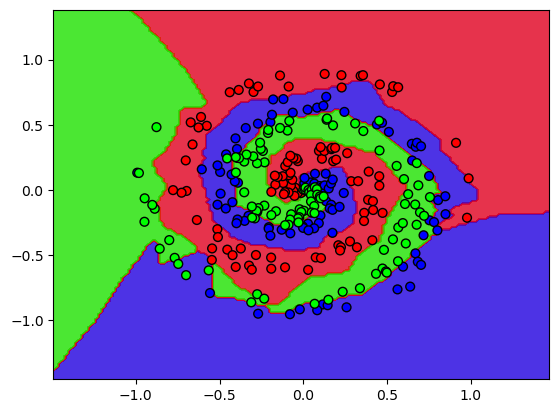

In [22]:
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, model_layers):
    # Tạo lưới điểm (mesh grid) bao phủ toàn bộ dữ liệu
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Flatten lưới điểm để đưa vào model dự đoán
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    
    # --- Forward Pass qua các layer (tùy chỉnh theo tên biến của bạn) ---
    # Ví dụ: dense1 -> act1 -> dense2 -> loss_act
    dense1.forward(mesh_data)
    activation1.forward(dense1.output)
    # Nếu có dropout thì lưu ý: khi test/predict thường ta không dùng dropout, 
    # hoặc scale output. Ở code from scratch này, hãy cẩn thận check logic đó.
    dense2.forward(activation1.output)
    # Lấy output cuối cùng (trước loss)
    scores = dense2.output 
    
    # Lấy class dự đoán
    Z = np.argmax(scores, axis=1)
    Z = Z.reshape(xx.shape)
    
    # Vẽ
    plt.contourf(xx, yy, Z, cmap='brg', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg', edgecolors='k')
    plt.show()

# Gọi hàm (nhớ tắt Dropout hoặc set rate=0 khi vẽ để chính xác nhất)
plot_decision_boundary(X_test, y_test, None)

In [23]:
import numpy as np
import copy 

X, y = spiral_data(samples=100, classes=3)

X_val, y_val = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

best_loss = float('inf') 
patience = 500           
patience_count = 0       
best_model_weights = {}  

# 4. TRAINING LOOP
for epoch in range(10001):
    # --- TRAINING PHASE ---
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    
    data_loss = loss_activation.forward(dense2.output, y)
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + \
                          loss_activation.loss.regularization_loss(dense2)
    loss = data_loss + regularization_loss

    # Tính Accuracy Training
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y_labels = np.argmax(y, axis=1)
    else:
        y_labels = y
    accuracy = np.mean(predictions == y_labels)

    dense1.forward(X_val)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    
    val_loss = loss_activation.forward(dense2.output, y_val)
    
    val_predictions = np.argmax(loss_activation.output, axis=1)
    if len(y_val.shape) == 2:
        y_val_labels = np.argmax(y_val, axis=1)
    else:
        y_val_labels = y_val
    val_accuracy = np.mean(val_predictions == y_val_labels)

    # --- EARLY STOPPING CHECK ---
    if val_loss < best_loss:
        best_loss = val_loss
        patience_count = 0 
        best_model_weights = {
            'dense1': copy.deepcopy(dense1),
            'dense2': copy.deepcopy(dense2)
        }
    else:
        patience_count += 1

    # --- LOGGING ---
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'val_acc: {val_accuracy:.3f}, ' + 
              f'val_loss: {val_loss:.3f}, ' +    
              f'patience: {patience_count}/{patience}, ' +
              f'lr: {optimizer.current_learning_rate}')

    if patience_count >= patience:
        print(f'Early stopping tại epoch {epoch}!')
        print(f'Validation loss thấp nhất đạt được: {best_loss:.3f}')
        break

    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss_activation.forward(dense2.output, y) 
    
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

print('Đang khôi phục weights tốt nhất...')
dense1 = best_model_weights['dense1']
dense2 = best_model_weights['dense2']

dense1.forward(X_val)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
final_val_acc = np.mean(np.argmax(dense2.output, axis=1) == y_val_labels)
print(f'Accuracy cuối cùng trên tập Validation: {final_val_acc:.3f}')

epoch: 0, acc: 0.307, loss: 1.099, val_acc: 0.297, val_loss: 1.099, patience: 0/500, lr: 0.02
epoch: 100, acc: 0.593, loss: 0.900, val_acc: 0.570, val_loss: 0.924, patience: 0/500, lr: 0.01998021958261321
epoch: 200, acc: 0.737, loss: 0.754, val_acc: 0.693, val_loss: 0.781, patience: 0/500, lr: 0.019960279044701046
epoch: 300, acc: 0.790, loss: 0.682, val_acc: 0.770, val_loss: 0.716, patience: 0/500, lr: 0.019940378268975763
epoch: 400, acc: 0.800, loss: 0.630, val_acc: 0.753, val_loss: 0.673, patience: 0/500, lr: 0.01992051713662487
epoch: 500, acc: 0.840, loss: 0.581, val_acc: 0.790, val_loss: 0.646, patience: 9/500, lr: 0.01990069552930875
epoch: 600, acc: 0.853, loss: 0.552, val_acc: 0.790, val_loss: 0.632, patience: 0/500, lr: 0.019880913329158343
epoch: 700, acc: 0.843, loss: 0.529, val_acc: 0.767, val_loss: 0.626, patience: 10/500, lr: 0.019861170418772778
epoch: 800, acc: 0.873, loss: 0.511, val_acc: 0.813, val_loss: 0.621, patience: 51/500, lr: 0.019841466681217078
epoch: 900,

DROPOUT

In [24]:
import numpy as np

class Layer_Dropout:
    # Initialize the dropout layer
    def __init__(self, rate):
        # Store the dropout rate, invert it to get the success rate
        # For example, for a dropout of 0.1, we need a success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save the scaled binary mask
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask


In [25]:
import numpy as np

# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64, weight_regularizer_l2 = 5e-4, bias_regularizer_l2 = 5e-4)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create dropout layer
dropout1 = Layer_Dropout(0.1)

# Create second Dense layer with 64 input features (as we take output of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through Dropout Layer
    dropout1.forward(activation1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(dropout1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    data_loss = loss_activation.forward(dense2.output, y)

    
    # Calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

    # Calculate overall loss 
    loss = data_loss + regularization_loss
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} ' +
              f'(data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()


epoch: 0, acc: 0.327, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.02
epoch: 100, acc: 0.507, loss: 0.961 (data_loss: 0.948, reg_loss: 0.013), lr: 0.01998021958261321
epoch: 200, acc: 0.510, loss: 0.893 (data_loss: 0.868, reg_loss: 0.025), lr: 0.019960279044701046
epoch: 300, acc: 0.610, loss: 0.843 (data_loss: 0.813, reg_loss: 0.030), lr: 0.019940378268975763
epoch: 400, acc: 0.607, loss: 0.811 (data_loss: 0.778, reg_loss: 0.032), lr: 0.01992051713662487
epoch: 500, acc: 0.640, loss: 0.803 (data_loss: 0.769, reg_loss: 0.034), lr: 0.01990069552930875
epoch: 600, acc: 0.647, loss: 0.824 (data_loss: 0.790, reg_loss: 0.034), lr: 0.019880913329158343
epoch: 700, acc: 0.653, loss: 0.834 (data_loss: 0.800, reg_loss: 0.034), lr: 0.019861170418772778
epoch: 800, acc: 0.630, loss: 0.823 (data_loss: 0.789, reg_loss: 0.034), lr: 0.019841466681217078
epoch: 900, acc: 0.627, loss: 0.834 (data_loss: 0.801, reg_loss: 0.033), lr: 0.01982180200001982
epoch: 1000, acc: 0.643, loss: 0.817 (data

In [26]:

# Validate the model
# Create test dataset
X_test, y_test = spiral_data(samples=100, classes=3)
# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
 y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation, acc: 0.707, loss: 0.691


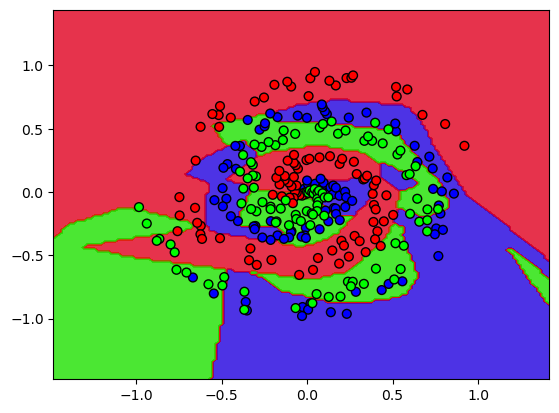

In [27]:
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, model_layers):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    
    dense1.forward(mesh_data)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    scores = dense2.output 
    
    Z = np.argmax(scores, axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap='brg', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg', edgecolors='k')
    plt.show()

plot_decision_boundary(X_test, y_test, None)

BUILD: BUILD THE LIBRARY

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

# ==========================================
# 1. HELPER FUNCTIONS & DATA
# ==========================================
def create_data(points, classes):
    X = np.zeros((points*classes, 2))
    y = np.zeros(points*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(points*class_number, points*(class_number+1))
        r = np.linspace(0.0, 1, points)
        t = np.linspace(class_number*4, (class_number+1)*4, points) + np.random.randn(points)*0.2
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y
def calculate_metrics_from_scratch(y_true, y_pred, num_classes=10):
    # 1. Compute Confusion Matrix
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        confusion_matrix[t][p] += 1
    
    # 2. Compute Precision & Recall per class
    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10}")
    print("-" * 35)
    
    for i in range(num_classes):
        tp = confusion_matrix[i][i]
        fn = np.sum(confusion_matrix[i, :]) - tp
        fp = np.sum(confusion_matrix[:, i]) - tp
        
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        print(f"{i:<10} {precision:.4f}     {recall:.4f}")
        
    return confusion_matrix
# ==========================================
# 2. LAYERS, ACTIVATIONS, LOSSES
# ==========================================
class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate 

    def forward(self, inputs):
        self.inputs = inputs
        
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

class Loss_CategoricalCrossentropy:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2: y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

# ==========================================
# 3. OPTIMIZERS
# ==========================================
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0, decay=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
    def pre_update_params(self):
        if self.decay: self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    def update_params(self, layer):
        layer.weights += -self.current_learning_rate * layer.dweights
        layer.biases += -self.current_learning_rate * layer.dbiases
    def post_update_params(self): self.iterations += 1

class Optimizer_SGD_Momentum:
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    def pre_update_params(self):
        if self.decay: self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    def update_params(self, layer):
        if not hasattr(layer, 'weight_momentums'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
        weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
        layer.weight_momentums = weight_updates
        bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
        layer.bias_momentums = bias_updates
        layer.weights += weight_updates
        layer.biases += bias_updates
    def post_update_params(self): self.iterations += 1

class Optimizer_Adagrad:
    def __init__(self, learning_rate=1.0, decay=0.0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
    def pre_update_params(self):
        if self.decay: self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
    def post_update_params(self): self.iterations += 1

class Optimizer_RMSProp:
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
    def pre_update_params(self):
        if self.decay: self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
    def post_update_params(self): self.iterations += 1

class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    def pre_update_params(self):
        if self.decay: self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    def update_params(self, layer):
        if not hasattr(layer, 'weight_momentums'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
    def post_update_params(self): self.iterations += 1

# ==========================================
# 4. NEURAL NETWORK MODEL CLASS
# ==========================================
class NeuralNetwork_Model:
    def __init__(self):
        self.layers = []
        self.loss_activation = None
        self.optimizer = None

    def add(self, layer):
        self.layers.append(layer)

    # ĐÃ SỬA: Thêm **kwargs vào đây để nhận learning_rate, decay...
    def compile(self, optimizer, loss, **kwargs):
        if isinstance(optimizer, str):
            optimizer = optimizer.lower()
            OptClass = None
            params = {}

            if optimizer == 'sgd':
                params = {'learning_rate': 1.0, 'decay': 1e-3}
                OptClass = Optimizer_SGD
            elif optimizer == 'sgd_momentum':
                params = {'learning_rate': 1.0, 'decay': 1e-3, 'momentum': 0.9}
                OptClass = Optimizer_SGD_Momentum
            elif optimizer == 'adagrad':
                params = {'learning_rate': 1.0, 'decay': 1e-4}
                OptClass = Optimizer_Adagrad
            elif optimizer == 'rmsprop':
                params = {'learning_rate': 0.02, 'decay': 1e-5}
                OptClass = Optimizer_RMSProp
            elif optimizer == 'adam':
                params = {'learning_rate': 0.05, 'decay': 5e-5}
                OptClass = Optimizer_Adam
            else:
                raise ValueError(f"Unknown optimizer string: {optimizer}")
            
            # Cập nhật params từ kwargs (ví dụ: learning_rate=0.01)
            params.update(kwargs)
            self.optimizer = OptClass(**params)
        else:
            self.optimizer = optimizer

        if isinstance(loss, str):
            if loss == 'categorical_crossentropy':
                self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
            else:
                 raise ValueError(f"Unknown loss string: {loss}")
        else:
            self.loss_activation = loss

    def forward(self, X):
        layer_output = X
        for layer in self.layers:
            layer.forward(layer_output)
            layer_output = layer.output
        return layer_output

    def backward(self, output, y):
        self.loss_activation.backward(output, y)
        dinputs = self.loss_activation.dinputs
        for layer in reversed(self.layers):
            layer.backward(dinputs)
            dinputs = layer.dinputs

    def fit(self, X, y, epochs=10000, print_every=1000):
        for epoch in range(epochs + 1):
            output = self.forward(X)
            loss = self.loss_activation.forward(output, y)
            predictions = np.argmax(self.loss_activation.output, axis=1)
            y_labels = np.argmax(y, axis=1) if len(y.shape) == 2 else y
            accuracy = np.mean(predictions == y_labels)
            
            if epoch % print_every == 0:
                print(f'epoch: {epoch}, loss: {loss:.3f}, accuracy: {accuracy:.3f}, ' +
                      f'lr: {self.optimizer.current_learning_rate:.5f}')
            
            self.backward(self.loss_activation.output, y)
            
            self.optimizer.pre_update_params()
            for layer in self.layers:
                if hasattr(layer, 'weights'):
                    self.optimizer.update_params(layer)
            self.optimizer.post_update_params()

    def predict(self, X):
        output = self.forward(X)
        self.loss_activation.activation.forward(output)
        return self.loss_activation.activation.output

    def save(self, filename):
        model_copy = copy.deepcopy(self)
        
        model_copy.loss_activation.output = None
        model_copy.loss_activation.dinputs = None
        for layer in model_copy.layers:
            layer.inputs = None
            layer.output = None
            layer.dinputs = None
            if hasattr(layer, 'dweights'): layer.dweights = None
            if hasattr(layer, 'dbiases'): layer.dbiases = None

        with open(filename, 'wb') as f:
            pickle.dump(model_copy, f)
        print(f"Model saved to {filename}")

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {filename}")
        return model
        


epoch: 0, loss: 1.099, accuracy: 0.360, lr: 0.05000
epoch: 1000, loss: 0.728, accuracy: 0.643, lr: 0.04762
epoch: 2000, loss: 0.677, accuracy: 0.683, lr: 0.04546
epoch: 3000, loss: 0.702, accuracy: 0.693, lr: 0.04348
epoch: 4000, loss: 0.751, accuracy: 0.670, lr: 0.04167
epoch: 5000, loss: 0.686, accuracy: 0.670, lr: 0.04000
epoch: 6000, loss: 0.694, accuracy: 0.687, lr: 0.03846
epoch: 7000, loss: 0.640, accuracy: 0.690, lr: 0.03704
epoch: 8000, loss: 0.633, accuracy: 0.700, lr: 0.03572
epoch: 9000, loss: 0.693, accuracy: 0.687, lr: 0.03448
epoch: 10000, loss: 0.809, accuracy: 0.667, lr: 0.03333
Model saved to adam.model
Class      Precision  Recall    
-----------------------------------
0          0.6634     0.6700
1          0.8252     0.8500
2          0.6250     0.6000


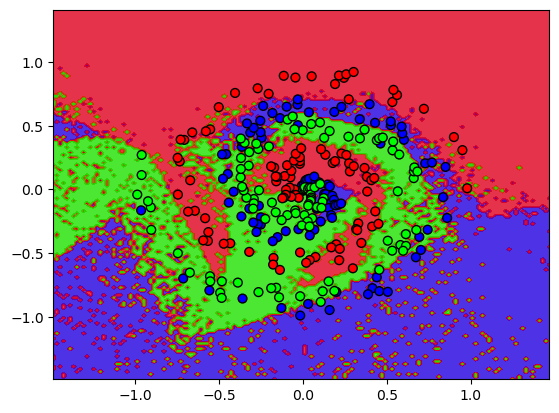

In [29]:

X, y = create_data(points=100, classes=3)

model = NeuralNetwork_Model()
model.add(Layer_Dense(2, 64))
model.add(Activation_ReLU())

model.add(Layer_Dropout(rate=0.1))

model.add(Layer_Dense(64, 3))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              #learning_rate=0.01,
              #decay=1e-4
              learning_rate=0.05,  
              decay=5e-5
             )

model.fit(X, y, epochs=10000, print_every=1000)
model.save('adam.model')

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict(mesh_data)
    Z = np.argmax(probs, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='brg', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg', edgecolors='k')
    plt.show()

cm = calculate_metrics_from_scratch(y, predictions, num_classes=3)
plot_decision_boundary(model, X, y)


In [30]:
print("Đang load model...")
model = NeuralNetwork_Model.load('adam.model')

X_new = np.array([
    [0.1, 0.8],
    [0.05, 0.9],
    [0.8, 0.1]
])

print(f"\nDữ liệu đầu vào:\n{X_new}")

probabilities = model.predict(X_new)
predictions = np.argmax(probabilities, axis=1)

class_names = ["Nhóm A", "Nhóm B", "Nhóm C"]

print("\n--- KẾT QUẢ DỰ ĐOÁN ---")
for i, input_data in enumerate(X_new):
    pred_idx = predictions[i]
    confidence = probabilities[i][pred_idx]
    print(f"Dữ liệu {input_data} --> Dự đoán: {class_names[pred_idx]} (Độ tin cậy: {confidence*100:.2f}%)")

Đang load model...
Model loaded from adam.model

Dữ liệu đầu vào:
[[0.1  0.8 ]
 [0.05 0.9 ]
 [0.8  0.1 ]]

--- KẾT QUẢ DỰ ĐOÁN ---
Dữ liệu [0.1 0.8] --> Dự đoán: Nhóm B (Độ tin cậy: 100.00%)
Dữ liệu [0.05 0.9 ] --> Dự đoán: Nhóm B (Độ tin cậy: 100.00%)
Dữ liệu [0.8 0.1] --> Dự đoán: Nhóm A (Độ tin cậy: 99.94%)


HYPERMETER TUNNING

In [32]:
# --- STEP 1: PREPARE DATA ---
X, y = create_data(points=100, classes=3)
X_test, y_test = create_data(points=100, classes=3)

# --- STEP 2: DEFINE HYPERPARAMETERS TO TUNE ---
learning_rates = [0.1, 0.05, 0.01]
decays = [1e-3, 5e-4]

best_acc = 0
best_config = {}

print(f"{'LR':<10} {'Decay':<10} {'Accuracy':<15} {'Status'}")
print("-" * 55)

# --- STEP 3: TUNING LOOP (GRID SEARCH) ---
for lr in learning_rates:
    for decay in decays:
        
        # 3.1. Initialize model (Use correct Class Name)
        model = NeuralNetwork_Model()
        
        # 3.2. Add layers
        model.add(Layer_Dense(2, 64))
        model.add(Activation_ReLU())
        model.add(Layer_Dense(64, 3))
        
        model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      learning_rate=lr, 
                      decay=decay)
        
        # 3.4. Train (FIT)
        model.fit(X, y, epochs=2000, print_every=1000000) 
        
        # 3.5. Evaluate
        probabilities = model.predict(X_test)
        predictions = np.argmax(probabilities, axis=1)
        
        if len(y_test.shape) == 2:
            y_test_idx = np.argmax(y_test, axis=1)
        else:
            y_test_idx = y_test
        
        val_acc = np.mean(predictions == y_test_idx)
        
        # 3.6. Compare results
        status = ""
        if val_acc > best_acc:
            best_acc = val_acc
            best_config = {'lr': lr, 'decay': decay}
            status = "<-- NEW BEST"
            
        print(f"{lr:<10} {decay:<10} {val_acc:.3f}            {status}")

# --- STEP 4: SUMMARY ---
print("\n" + "="*30)
print(f"Best Configuration: LR={best_config['lr']}, Decay={best_config['decay']}")
print(f"Highest Accuracy: {best_acc:.3f}")

LR         Decay      Accuracy        Status
-------------------------------------------------------
epoch: 0, loss: 1.099, accuracy: 0.343, lr: 0.10000
0.1        0.001      0.770            <-- NEW BEST
epoch: 0, loss: 1.099, accuracy: 0.313, lr: 0.10000
0.1        0.0005     0.780            <-- NEW BEST
epoch: 0, loss: 1.099, accuracy: 0.370, lr: 0.05000
0.05       0.001      0.797            <-- NEW BEST
epoch: 0, loss: 1.099, accuracy: 0.320, lr: 0.05000
0.05       0.0005     0.790            
epoch: 0, loss: 1.099, accuracy: 0.280, lr: 0.01000
0.01       0.001      0.783            
epoch: 0, loss: 1.099, accuracy: 0.357, lr: 0.01000
0.01       0.0005     0.707            

Best Configuration: LR=0.05, Decay=0.001
Highest Accuracy: 0.797


2025-12-25 19:03:05.096853: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-25 19:03:06.964843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766664187.497477    7530 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766664187.654965    7530 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766664189.154644    7530 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Đang tải bộ dữ liệu MNIST (Chữ viết tay)...
Shape đầu vào sau khi duỗi: (2000, 784)

--- Bắt đầu Training (Ngồi đợi xíu nhé) ---
epoch: 0, loss: 2.303, accuracy: 0.072, lr: 0.00500
epoch: 10, loss: 1.497, accuracy: 0.537, lr: 0.00496
epoch: 20, loss: 0.692, accuracy: 0.770, lr: 0.00491
epoch: 30, loss: 0.467, accuracy: 0.842, lr: 0.00486
epoch: 40, loss: 0.321, accuracy: 0.899, lr: 0.00481
epoch: 50, loss: 0.209, accuracy: 0.938, lr: 0.00477
epoch: 60, loss: 0.154, accuracy: 0.956, lr: 0.00472
epoch: 70, loss: 0.106, accuracy: 0.969, lr: 0.00468
epoch: 80, loss: 0.071, accuracy: 0.984, lr: 0.00463
epoch: 90, loss: 0.054, accuracy: 0.988, lr: 0.00459
epoch: 100, loss: 0.040, accuracy: 0.992, lr: 0.00455

--- Đang chạy thử trên tập Test ---
Độ chính xác trên tập kiểm tra: 90.00%
Class      Precision  Recall    
-----------------------------------
0          0.8889     1.0000
1          1.0000     1.0000
2          0.7000     0.8750
3          0.9000     0.8182
4          0.9286     0.928

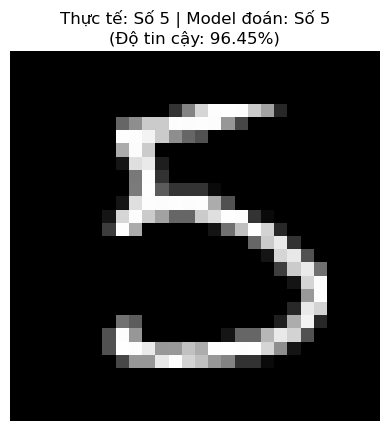

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Chỉ dùng để tải data

# --- 1. TẢI VÀ XỬ LÝ DỮ LIỆU ---
print("Đang tải bộ dữ liệu MNIST (Chữ viết tay)...")
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = tf.keras.datasets.mnist.load_data()

# CẮT BỚT DỮ LIỆU ĐỂ DEMO CHO NHANH (Lấy 2000 ảnh train, 100 ảnh test)
# Nếu máy khỏe, bạn có thể bỏ dòng này để train full
X_train_orig = X_train_orig[:2000]
y_train_orig = y_train_orig[:2000]
X_test_orig = X_test_orig[:100]
y_test_orig = y_test_orig[:100]

# --- QUAN TRỌNG: DUỖI PHẲNG ẢNH (FLATTEN) ---
# Ảnh gốc: (28, 28) --> Duỗi thành: (784,)
# Và chia cho 255 để chuẩn hóa dữ liệu về khoảng [0, 1] cho Model dễ học
X_train = X_train_orig.reshape(X_train_orig.shape[0], -1) / 255.0
X_test = X_test_orig.reshape(X_test_orig.shape[0], -1) / 255.0

# y (Nhãn) giữ nguyên, không cần one-hot vì Loss của ta xử lý được
y_train = y_train_orig
y_test = y_test_orig

print(f"Shape đầu vào sau khi duỗi: {X_train.shape}") # Sẽ là (2000, 784)

# --- 2. XÂY DỰNG MODEL ---
model = NeuralNetwork_Model()

# Layer 1: Nhận 784 input (tương ứng 784 pixel của ảnh)
model.add(Layer_Dense(784, 64)) 
model.add(Activation_ReLU())

model.add(Layer_Dropout(rate=0.1))
# Layer 2: Hidden layer
model.add(Layer_Dense(64, 64))
model.add(Activation_ReLU())

# Layer 3: Output 10 nhóm (Số 0 đến Số 9)
model.add(Layer_Dense(64, 10)) 

# --- 3. COMPILE & TRAIN ---
# Dùng learning_rate nhỏ hơn xíu vì bài toán này phức tạp hơn Spiral
model.compile(optimizer='adam', loss='categorical_crossentropy', learning_rate=0.005, decay=1e-3)

print("\n--- Bắt đầu Training (Ngồi đợi xíu nhé) ---")
model.fit(X_train, y_train, epochs=100, print_every=10) # 50 epoch thôi

# --- 4. KIỂM TRA KẾT QUẢ ---
print("\n--- Đang chạy thử trên tập Test ---")
probabilities = model.predict(X_test)
predictions = np.argmax(probabilities, axis=1)
accuracy = np.mean(predictions == y_test)
print(f"Độ chính xác trên tập kiểm tra: {accuracy * 100:.2f}%")


cm = calculate_metrics_from_scratch(y_test, predictions, num_classes=10)
# --- 5. VẼ HÌNH MINH HỌA ---
# Lấy ngẫu nhiên 1 ảnh để test
idx = np.random.randint(0, len(X_test))
img_vector = X_test[idx] # Dạng duỗi (784,)
img_matrix = X_test_orig[idx] # Dạng ảnh gốc (28, 28) để vẽ

# Dự đoán
probs = model.predict(img_vector.reshape(1, -1)) # Reshape thành (1, 784) để đưa vào model
pred_label = np.argmax(probs)
true_label = y_test[idx]

plt.imshow(img_matrix, cmap='gray')
plt.title(f"Thực tế: Số {true_label} | Model đoán: Số {pred_label}\n(Độ tin cậy: {np.max(probs)*100:.2f}%)")
plt.axis('off')
plt.show()

Loading CIFAR-10 dataset...
Training Data Shape: (5000, 3072)
Training Labels Shape: (5000,)

--- Starting Training (5000 samples) ---
epoch: 0, loss: 2.303, accuracy: 0.104, lr: 0.00100
epoch: 10, loss: 2.117, accuracy: 0.209, lr: 0.00100
epoch: 20, loss: 2.011, accuracy: 0.263, lr: 0.00100
epoch: 30, loss: 1.923, accuracy: 0.300, lr: 0.00100
epoch: 40, loss: 1.862, accuracy: 0.322, lr: 0.00100
epoch: 50, loss: 1.810, accuracy: 0.347, lr: 0.00100
epoch: 60, loss: 1.758, accuracy: 0.367, lr: 0.00100
epoch: 70, loss: 1.710, accuracy: 0.381, lr: 0.00100
epoch: 80, loss: 1.671, accuracy: 0.399, lr: 0.00100
epoch: 90, loss: 1.639, accuracy: 0.414, lr: 0.00100
epoch: 100, loss: 1.621, accuracy: 0.415, lr: 0.00100

--- Evaluating on Test Set ---
Test Accuracy: 34.20%

Class           Precision  Recall    
----------------------------------------
Airplane        0.3231     0.3684
Automobile      0.4878     0.4878
Bird            0.3611     0.2549
Cat             0.2400     0.1224
Deer        

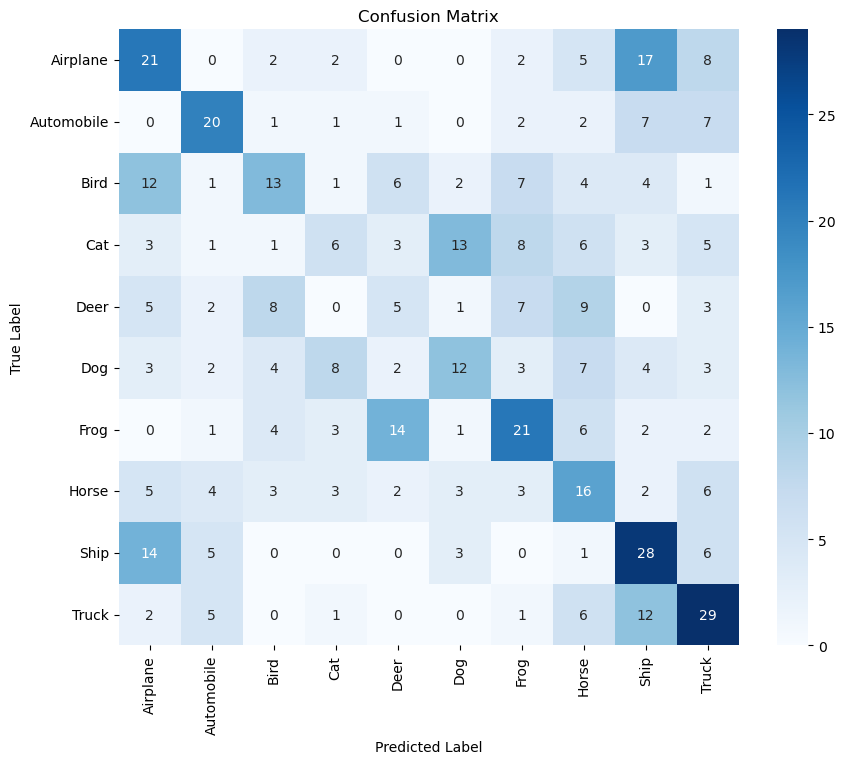

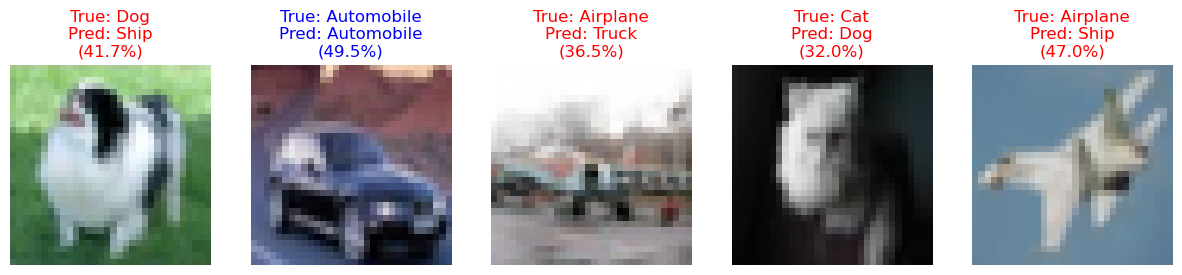

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import seaborn as sns

# =============================================
# 0. HELPER FUNCTIONS (METRICS)
# =============================================
def calculate_metrics_from_scratch(y_true, y_pred, class_names):
    num_classes = len(class_names)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    # Compute Confusion Matrix
    for t, p in zip(y_true, y_pred):
        confusion_matrix[t][p] += 1
    
    # Print Precision & Recall
    print(f"\n{'Class':<15} {'Precision':<10} {'Recall':<10}")
    print("-" * 40)
    
    for i in range(num_classes):
        tp = confusion_matrix[i][i]
        fn = np.sum(confusion_matrix[i, :]) - tp
        fp = np.sum(confusion_matrix[:, i]) - tp
        
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        print(f"{class_names[i]:<15} {precision:.4f}     {recall:.4f}")
        
    return confusion_matrix

# =============================================
# 1. DATA LOADING & PREPROCESSING
# =============================================
print("Loading CIFAR-10 dataset...")
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = tf.keras.datasets.cifar10.load_data()

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Configuration
NUM_TRAIN = 5000
NUM_TEST = 500

# Slicing and Flattening Data
X_train = X_train_orig[:NUM_TRAIN].reshape(NUM_TRAIN, -1) / 255.0
y_train = y_train_orig[:NUM_TRAIN].flatten()

X_test = X_test_orig[:NUM_TEST].reshape(NUM_TEST, -1) / 255.0
y_test = y_test_orig[:NUM_TEST].flatten()

print(f"Training Data Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")

# =============================================
# 2. MODEL ARCHITECTURE
# =============================================
model = NeuralNetwork_Model()

# Layer 1: Input (3072) -> Hidden (256)
model.add(Layer_Dense(3072, 256))
model.add(Activation_ReLU())
model.add(Layer_Dropout(rate=0.2))

# Layer 2: Hidden (256) -> Hidden (128)
model.add(Layer_Dense(256, 128))
model.add(Activation_ReLU())
model.add(Layer_Dropout(rate=0.2))

# Layer 3: Output (10 Classes)
model.add(Layer_Dense(128, 10))

# =============================================
# 3. TRAINING
# =============================================
model.compile(optimizer='adam', loss='categorical_crossentropy',
              learning_rate=0.001, decay=1e-5)

print(f"\n--- Starting Training ({NUM_TRAIN} samples) ---")
model.fit(X_train, y_train, epochs=100, print_every=10)

# =============================================
# 4. EVALUATION & METRICS
# =============================================
print("\n--- Evaluating on Test Set ---")
probabilities = model.predict(X_test)
predictions = np.argmax(probabilities, axis=1)

# Overall Accuracy
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Detailed Metrics (Precision, Recall, Confusion Matrix)
cm = calculate_metrics_from_scratch(y_test, predictions, class_names)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# =============================================
# 5. VISUALIZATION
# =============================================
indices = np.random.choice(len(X_test), 5, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    img_vector = X_test[idx]
    img_matrix = X_test_orig[:NUM_TEST][idx] # Get original image for display

    probs = model.predict(img_vector.reshape(1, -1))
    pred_label_idx = np.argmax(probs)
    true_label_idx = y_test[idx]
    confidence = np.max(probs) * 100

    color = 'blue' if pred_label_idx == true_label_idx else 'red'

    plt.subplot(1, 5, i+1)
    plt.imshow(img_matrix)
    plt.title(f"True: {class_names[true_label_idx]}\nPred: {class_names[pred_label_idx]}\n({confidence:.1f}%)", color=color)
    plt.axis('off')
plt.show()